In [ ]:
# default_exp auto_feature_extraction

# ImageFeatureExtractor
> Use transfer learning models to convert images into vectors with features

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
# All Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from PIL import ImageFile
import glob
ImageFile.LOAD_TRUNCATED_IMAGES = True #https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torchvision.transforms as transforms

# All Parameters
PROJECT_FOLDER = '/content/drive/MyDrive/projects/kNearestPet'
DATA_PATH = 'cats-dogs-data/'

DOGSCATS='http://files.fast.ai/data/examples/dogscats.tgz'
DOG_BREED_URL = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip'
ZIP_FILENAME = 'cats-dogs-data.zip'
PETS='https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz'

# Assign training and validation folders
TRAIN_PATH = f'{DATA_PATH}train/'
VALID_PATH = f'{DATA_PATH}valid/'

# Functions and classes
def download_dataset(data_url, zip_filename):
    try: # Then try downloading and unzipping it
        print("Downloading Dataset...")
        os.system(f"wget {data_url}")

        print("Unzipping Dataset")
        if 'tgz' in zip_filename:
            os.system(f"tar -xvzf {zip_filename}")
        else:
            os.system(f"unzip {zip_filename}")

        print("Removing .zip file")
        os.system(f"rm {zip_filename}")
    except Exception as e: # If there's an error, ask to download manually
        print(f"Something went wrong. Please download the dataset manually at {data_url}")
        print(f'The following exception was thrown:\n{e}')

class ImageFeatureExtractor():
  def __init__(self, model_name='resnet', target_shape=(224, 224, 3)):
    self.target_shape = target_shape
    self.model = self._get_model(model_name)
    self.model_name = model_name

  def _center_crop_img(self, img, size=224): #using pytorch as it gives more freedom in the transformations
    tr = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
    ])  
    return tr(img)
  
  def prepare_img_torch(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    img = transform(img)

    # Add batch dimension
    img = img.unsqueeze(0)

    return img

  def _get_model(self, model_name):
    if model_name=='resnet':
      base_model = ResNet50(include_top=False, input_shape=self.target_shape)
      for layer in base_model.layers:
        layer.trainable=False
          
      model = Sequential([base_model,
                          GlobalAveragePooling2D()])
    return model

  def img_to_vector(self, img):
    img_np = self._preprocess_img(img)
    vector = self.model.predict(img_np)
    return vector

  def _get_img_gen_from_df(self, dataframe, batch_size=32):

    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    gen = datagen.flow_from_dataframe(dataframe,
                                      batch_size=batch_size,
                                    target_size=self.target_shape[:2], 
                                    class_mode=None,
                                    shuffle=False)
    return gen
    
  def _get_img_gen(self, folder_path, batch_size=32):

    # TODO: Initialize the data generator class 
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # TODO: Create the training and validation generators using the method flow_from_directory
    gen = datagen.flow_from_directory(folder_path,
                                      batch_size=batch_size,
                                      target_size=self.target_shape[:2], 
                                      class_mode='sparse',
                                      shuffle=False)
    return gen

  def extract_features_from_directory(self, 
                                      directory, 
                                      batch_size=32, 
                                      classes_as_folders=True, 
                                      include_classes=False, 
                                      return_class_indices=False):
    if classes_as_folders:
      gen = self._get_img_gen(directory, batch_size)
    else:
      filepaths = glob.glob(directory+'/*.*')
      dataframe=pd.DataFrame(filepaths, columns=['filename'])
      gen = self._get_img_gen_from_df(dataframe, batch_size)
    all_vectors=self.model.predict(gen, verbose=1)
    df=pd.DataFrame(all_vectors)
    df['filepaths']=gen.filepaths
    if classes_as_folders and include_classes:
      df['classes']=gen.classes
      if return_class_indices:
        return df, gen.class_indices
    return df

  def url_to_vector(self, url):
    img = self.read_img_url(url)
    vector = self.img_to_vector(img)
    return vector

  def read_img_url(self, url, center_crop=True):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    if center_crop:
      img = self._center_crop_img(img)
    return img

  def vectors_from_folder_list(self, folder_list):
    df_list = []
    for folder_path in folder_list:
      df=self.img_folder_to_vectors(folder_path)
      df_list.append(df)
    return pd.concat(df_list)

    
  def _preprocess_img(self, img):
    # Convert to a Numpy array
    img_np = np.asarray(img)

    # Reshape by adding 1 in the beginning to be compatible as input of the model
    img_np = img_np[None] # https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#numpy.newaxis

    # Prepare the image for the model
    img_np = preprocess_input(img_np)

    return img_np

## Test

/Users/wittmann/anaconda/envs/udacity-update/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


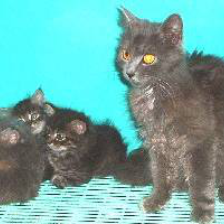

In [ ]:
ife = ImageFeatureExtractor()
url='https://raw.githubusercontent.com/WittmannF/ImageDataGenerator-example/master/flow_from_dataframe/train/cat.101.jpg'
img=ife.read_img_url(url)
img

In [ ]:
vector=ife.img_to_vector(img)
vector

array([[0.11309581, 0.36642522, 0.12123457, ..., 0.17095788, 0.8321816 ,
        0.1164221 ]], dtype=float32)

In [ ]:
df=ife.extract_features_from_directory('./sample_data/cats_vs_dogs/train',
                                       include_classes=True)
df.head()

Found 256 images belonging to 2 classes.
8/8 [==============================] - 74s 9s/step


,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,filepaths,classes
0,0.133268,0.416758,1.458256,3.465919,1.363020,0.015364,0.013365,1.423097,0.413051,0.010663,...,1.845307,0.395472,0.001949,0.894988,1.073747,1.694634,0.374132,0.520977,./sample_data/cats_vs_dogs/train/cat/cat.0.jpg,0
1,0.301924,1.074781,0.000000,0.243070,0.353256,0.063934,0.103987,0.011720,0.000000,0.043833,...,0.204798,0.089238,0.000000,0.000000,0.182651,0.046991,0.007193,0.000000,./sample_data/cats_vs_dogs/train/cat/cat.1.jpg,0
2,0.071524,0.014293,0.007412,0.205923,0.520102,0.099297,0.057757,0.000000,0.000000,0.118381,...,0.000000,1.286243,0.030465,0.000000,0.784970,0.184107,0.146302,0.191065,./sample_data/cats_vs_dogs/train/cat/cat.10.jpg,0
3,0.405527,0.018546,0.059608,0.540772,1.073777,0.011074,0.029712,0.002353,0.000000,0.420814,...,0.186881,0.821028,0.000000,0.617143,0.128354,0.062721,1.133202,0.188214,./sample_data/cats_vs_dogs/train/cat/cat.100.jpg,0
4,0.097891,0.686931,0.316419,0.057576,0.385978,1.373904,0.181614,0.015783,0.152097,0.047016,...,0.046708,1.474841,0.630403,0.124097,1.022476,0.216485,0.725319,0.006628,./sample_data/cats_vs_dogs/train/cat/cat.101.jpg,0


## Cases

In [ ]:
train=df

test=ife.extract_features_from_directory('./sample_data/cats_vs_dogs/valid',
                                       include_classes=True)

Found 64 images belonging to 2 classes.
2/2 [==============================] - 18s 9s/step


In [ ]:
X_train, y_train = train.drop(['filepaths', 'classes'], axis=1), train['classes']

In [ ]:
X_test, y_test = test.drop(['filepaths', 'classes'], axis=1), test['classes']

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression().fit(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

1.0

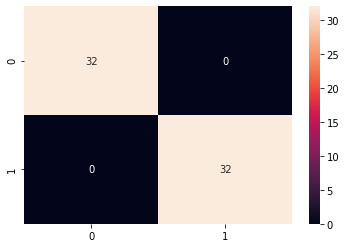

In [ ]:
import seaborn as sns
y_pred=lr.predict_proba(X_test)[:, 1]
sns.heatmap(confusion_matrix(y_test, y_pred>0.6), annot=True)